<a href="https://colab.research.google.com/github/prajjval30/2021-02-15-ML-SP-online/blob/gh-pages/Yolo5s_Custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing And Initializing Yolo

In [34]:
# Download YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# Install dependencies
%pip install -qr requirements.txt  # install dependencies

%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 8099, done.
remote: Counting objects: 100% (411/411), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 8099 (delta 285), reused 346 (delta 241), pack-reused 7688
Receiving objects: 100% (8099/8099), 9.43 MiB | 3.68 MiB/s, done.
Resolving deltas: 100% (5581/5581), done.
/content/yolov5/yolov5
/content/yolov5
Setup complete. Using torch 1.9.0+cu102 (Tesla K80)


In [13]:
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


## Wana-b Installation

In [35]:
# Install W&B 
!pip install -q --upgrade wandb
# Login 
import wandb
wandb.login()


wandb: Currently logged in as: prajjval (use `wandb login --relogin` to force relogin)


True

### Download Data


In [36]:
# Export code snippet and paste here
%cd /content/
!curl -L "https://public.roboflow.com/ds/BQRv4cqZlD?key=gmcINX6qak" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1413      0 --:--:-- --:--:-- --:--:--  1413
100 7835k  100 7835k    0     0  3816k      0  0:00:02  0:00:02 --:--:-- 6454k
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
 extracting: test/images/BloodImage_00038_jpg.rf.63d04b5c9db95f32fa7669f72e4903ca.jpg  
 extracting: test/images/BloodImage_00044_jpg.rf.589ee3d351cb6d9a3f7b7a942da5370a.jpg  
 extracting: test/images/BloodImage_00062_jpg.rf.1cecc20a21ac39cb54cf532081a1e893.jpg  
 extracting: test/images/BloodImage_00090_jpg.rf.5267690cb6a13608d39b0424bef3c9b4.jpg  
 extracting: test/images/BloodImage_00099_jpg.rf.744666666386a07e242e214e041945ba.jpg  
 extracting: test/images/Blood

### Updating Data.Yaml

In [37]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['Platelets', 'RBC', 'WBC']


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

In [39]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [40]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml


# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-

In [41]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [42]:
%%writetemplate /content/yolov5/models/yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

### Train

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py \
  --img 416 \
  --batch 8 \
  --epochs 20 \
  --data '../data.yaml' \
  --cfg ./models/yolov5l.yaml \
  --weights '' \
  --bbox_interval 1 \
  --save_period 1 \
  --name yolov5l_results  \
  --cache 

/content/yolov5
train: weights=, cfg=./models/yolov5l.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=20, batch_size=8, img_size=[416], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=None, bucket=, cache_images=True, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=yolov5l_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=1, save_period=1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-287-gd204a61 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, t

# Evaluate Custom YOLOv5 Detector Performance

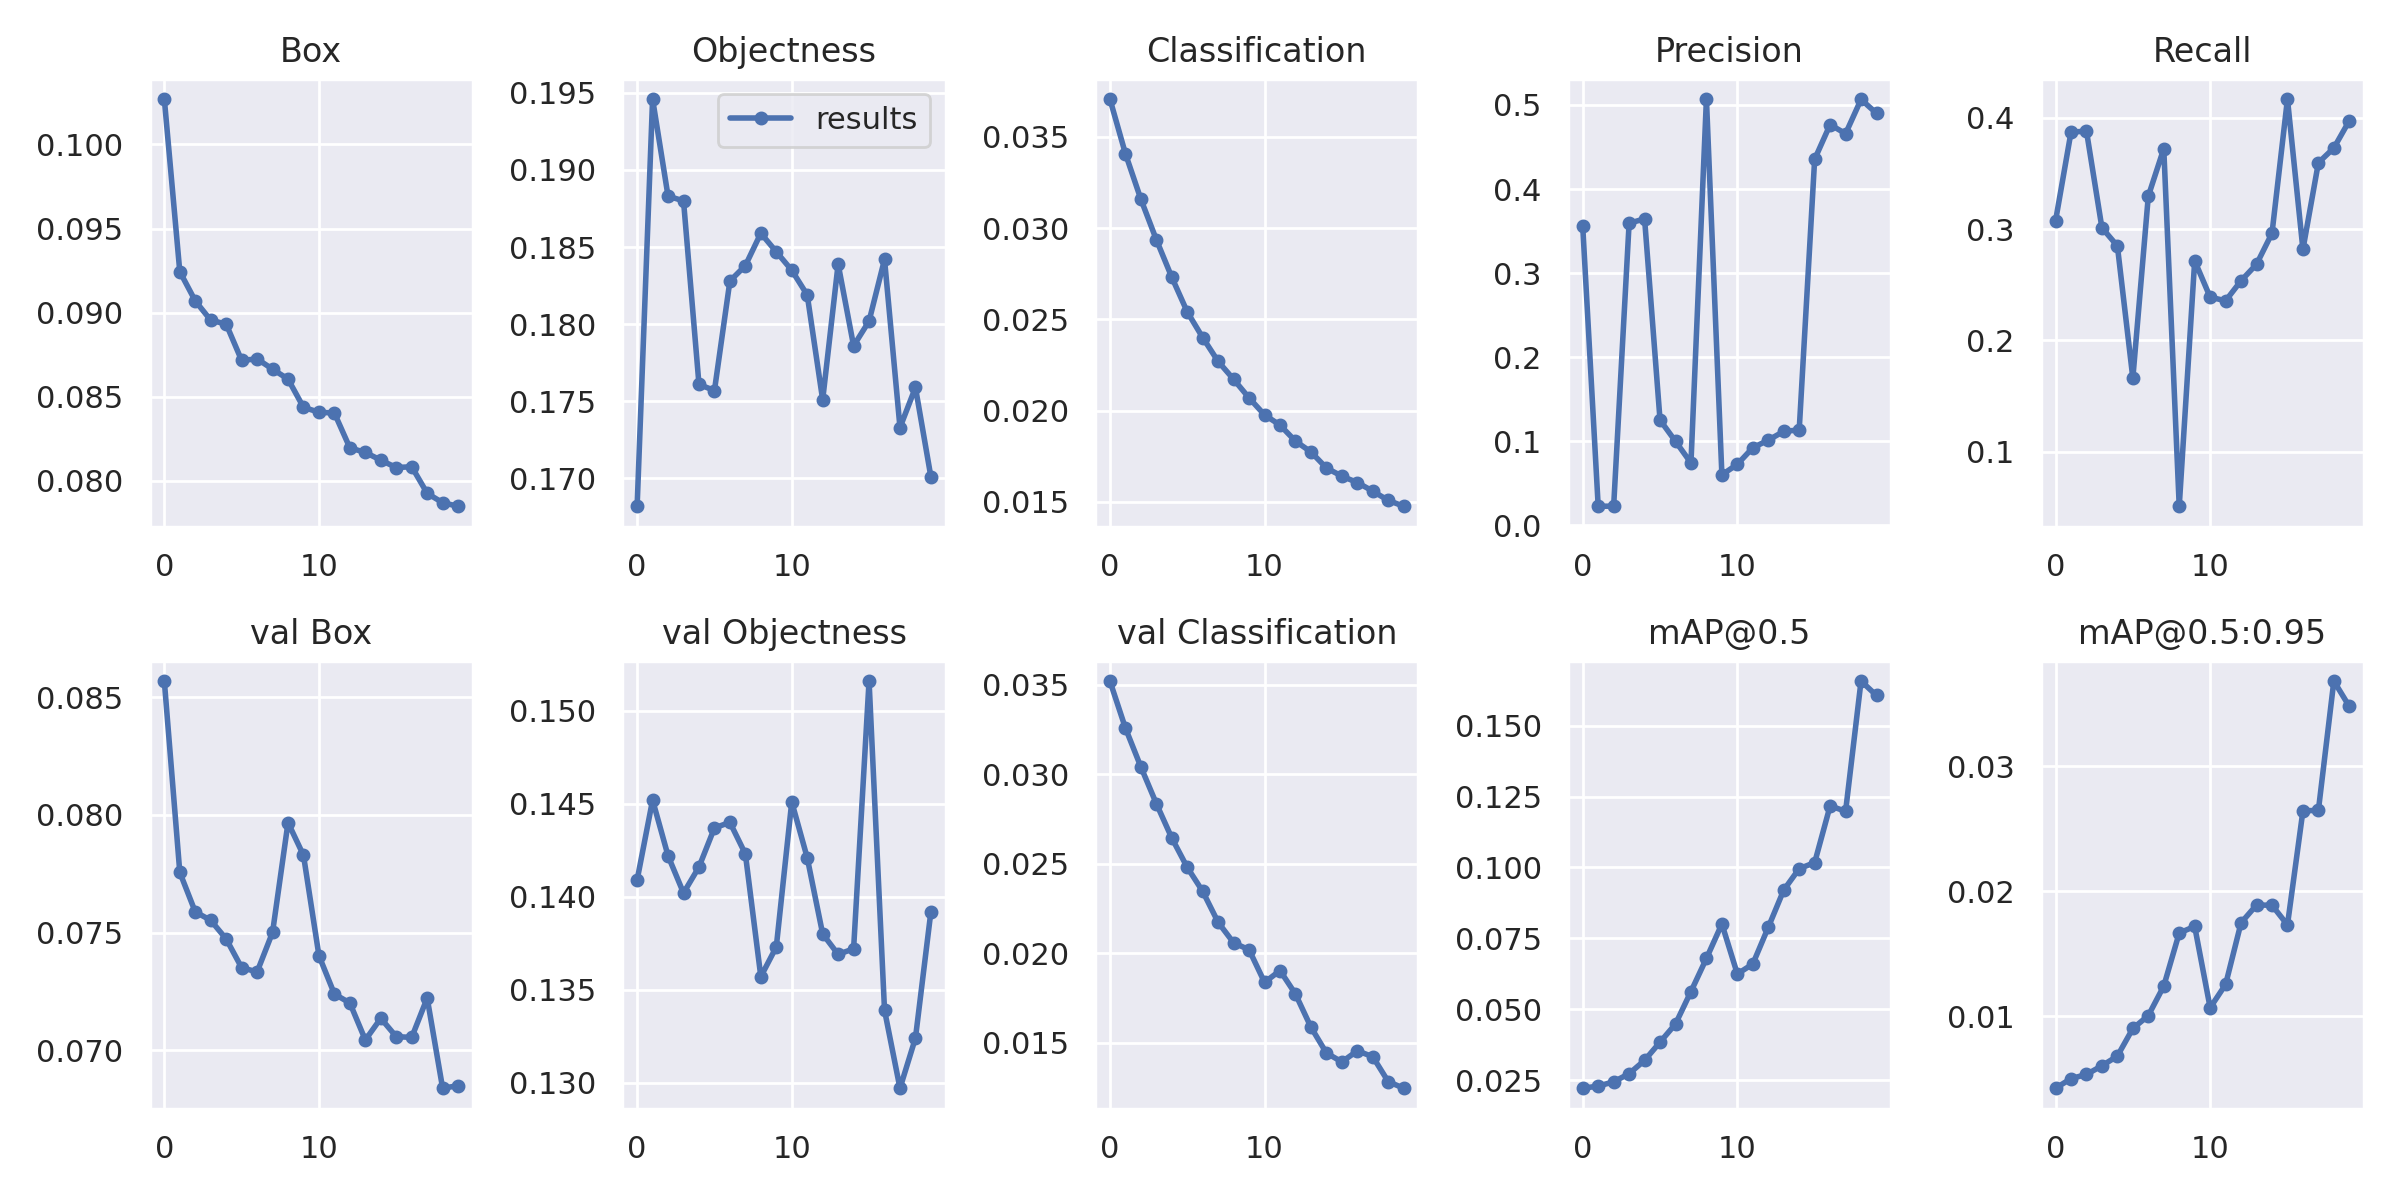

In [22]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Visualize Training Data with Labels
After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

GROUND TRUTH TRAINING DATA:


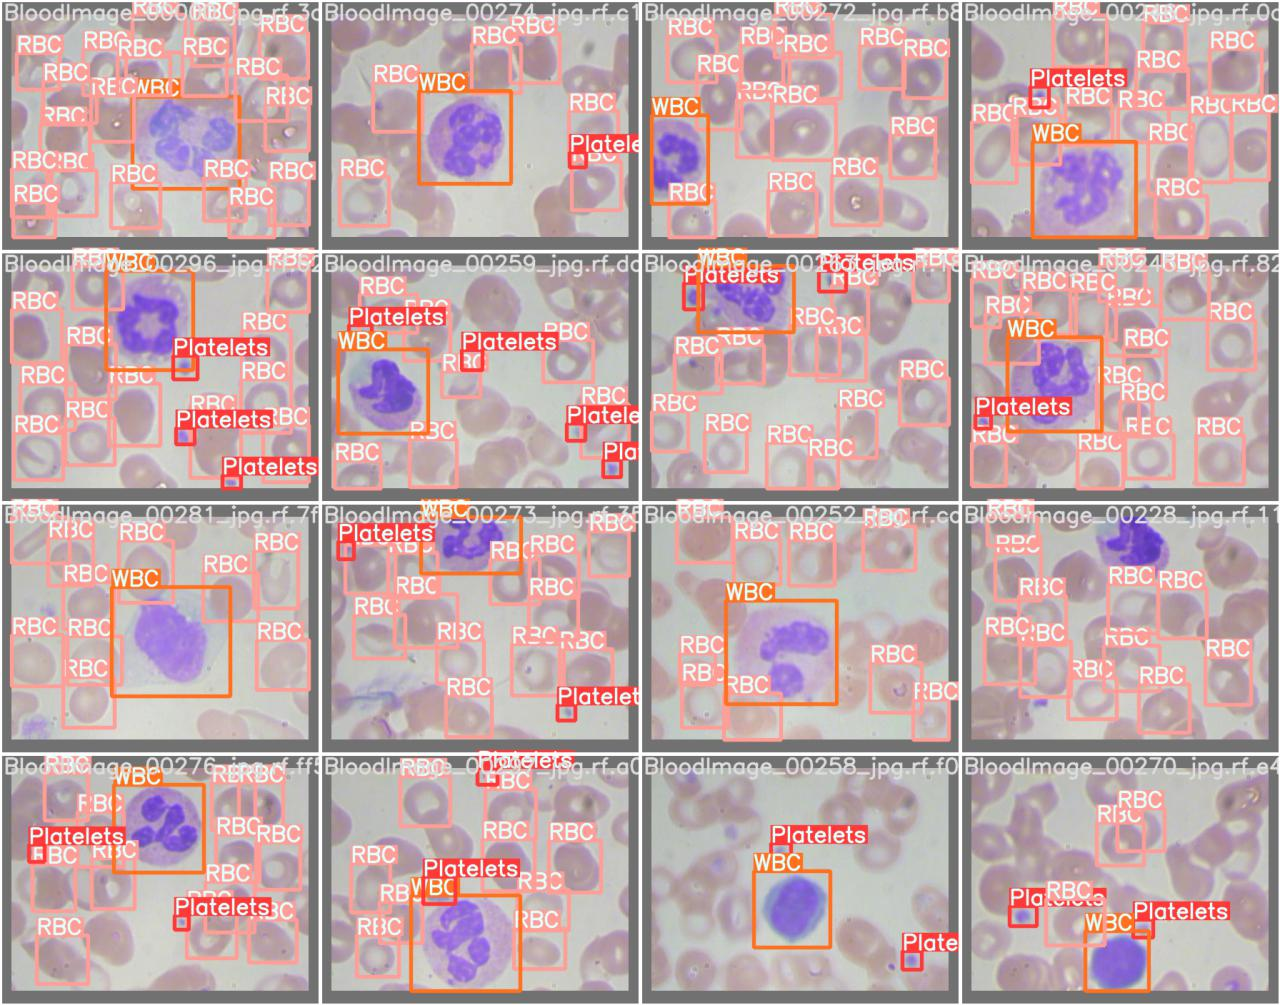

In [23]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


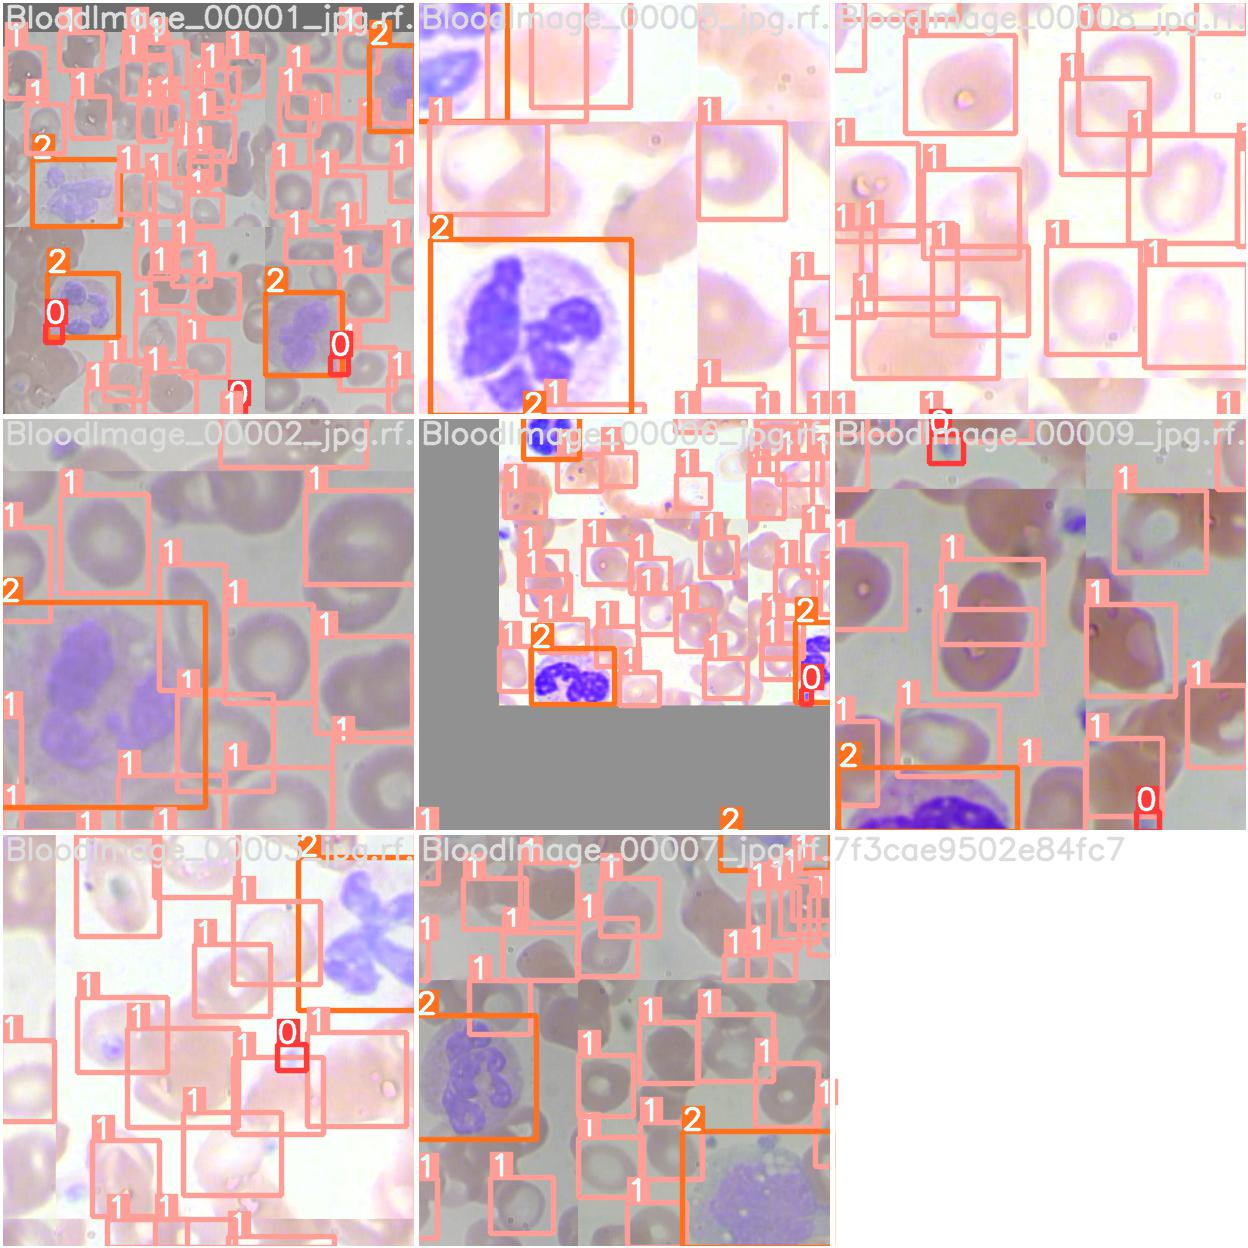

In [17]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [24]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5m_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

/content/yolov5
detect: weights=['runs/train/yolov5m_results/weights/best.pt'], source=../test/images, imgsz=416, conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-287-gd204a61 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 308 layers, 21045720 parameters, 0 gradient

In [38]:
!rm -rf /content/yolov5/yolov5